# **Speeding Up Inference with TensorRT**

## YOLO-V5

In [ ]:
!pip install torch torch-tensorrt tensorrt --extra-index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 23.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 52.6 MB/s eta 0:00:00
  Created wheel for tensorrt: filename=tensorrt-10.1.0-py2.py3-none-any.whl size=16333 sha256=b579dd43c1dfad509e44e88ea1dc3094a974043d66bde6ba4360beef99c1ea39
  Stored in directory: /root/.cache/pip/wheels/f5/55/f5/a1836546c0d92da062e9365a0323953f5e6a0a5f51d46da503
  Created wheel for tensorrt-cu12-libs: filename=tensorrt_cu12_libs-10.1.0-py2.py3-none-manylinux_2_17_x86_64.whl size=1056270840 sha256=1ad13c26b3f441267a

In [ ]:
!pip install opencv-python
!pip install numpy
!pip install pandas
!pip install matplotlib

In [ ]:
import torch
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Use GPU for inference
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:295: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


requirements: Ultralytics requirements ['gitpython>=3.1.30', 'pillow>=10.3.0'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 199.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 283.5 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0

requirements: AutoUpdate success ✅ 3.9s, installed 2 packages: ['gitpython>=3.1.30', 'pillow>=10.3.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5 🚀 2024-8-28 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 340MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


cuda


In [ ]:
# Download COCO validation data set
!wget http://images.cocodataset.org/zips/val2017.zip
!unzip val2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: val2017/000000212226.jpg  
 extracting: val2017/000000231527.jpg  
 extracting: val2017/000000578922.jpg  
 extracting: val2017/000000062808.jpg  
 extracting: val2017/000000119038.jpg  
 extracting: val2017/000000114871.jpg  
 extracting: val2017/000000463918.jpg  
 extracting: val2017/000000365745.jpg  
 extracting: val2017/000000320425.jpg  
 extracting: val2017/000000481404.jpg  
 extracting: val2017/000000314294.jpg  
 extracting: val2017/000000335328.jpg  
 extracting: val2017/000000513688.jpg  
 extracting: val2017/000000158548.jpg  
 extracting: val2017/000000132116.jpg  
 extracting: val2017/000000415238.jpg  
 extracting: val2017/000000321333.jpg  
 extracting: val2017/000000081738.jpg  
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/00000011

In [ ]:
# Iterate through the images in the dataset
import os
import cv2

def prepare_images(image_paths):

    images = []
    for image_path in image_paths:
      image = cv2.imread(image_path)

      # Preprocess the image
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (640, 640))

      image = image.transpose((2, 0, 1)) # W, H, C => C, H, W
      image = torch.from_numpy(image).to(device)
      image = image.float() / 255.0 # Normalize [0;1]
      images.append(image)

    return images

In [ ]:
# Load COCO dataset
image_dir = 'val2017'
image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir)]

# Only take a subset of COCO
IMAGE_NUMS = 128
images = prepare_images(image_paths[:IMAGE_NUMS])

In [ ]:
import time

def run_inference(model, images):
  times = []
  results = []
  for image in images:
    # Move image to GPU, if not already
    image = image.unsqueeze(0)
    image_gpu = image.to('cuda')

    # Run inference with no gradient calculation
    start = time.time()
    with torch.no_grad():
        result = model(image_gpu)

    results.append(result)
    times.append(time.time() - start)

  return results, times

In [ ]:
NUM_TRIALS = 10
avgs = []

for i in range(NUM_TRIALS):
    results, times = run_inference(model, images)
    avg = sum(times)/len(times)
    print("Average inference time (s):", avg)
    avgs.append(avg)

mat = sum(avgs)/NUM_TRIALS
print("Mean average inference time (s):", mat)

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.am

Average inference time (s): 0.009733373299241066


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.am

Average inference time (s): 0.009321045130491257


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.am

Average inference time (s): 0.01056428998708725


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.am

Average inference time (s): 0.013698315247893333


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.am

Average inference time (s): 0.008030222728848457


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.am

Average inference time (s): 0.007352350279688835


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.am

Average inference time (s): 0.007311129942536354


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.am

Average inference time (s): 0.007364608347415924


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.am

Average inference time (s): 0.007483715191483498


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.am

Average inference time (s): 0.011006185784935951
Mean average inference time (s): 0.009186523593962192


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


# **Accelerating the model with TensorRT**

In [ ]:
import torch
import torch_tensorrt



model.eval()
input_data = torch.randn(1, 3, 640, 640)  # (1,3,640,640)인 이미지 예시 batch 1

# 아래와 같이 설정을 해줘야 에러가 나지 않음
ts_model = torch.jit.trace(model, input_data, strict=False)

# TensorRT 모델을 compile할때 필요한 설정값 조정
trt_model = torch_tensorrt.compile(ts_model,
                                   inputs=[torch_tensorrt.Input(input_data.shape)],
                                   ir='ts',
                                   enabled_precisions={torch.float32},  # float32로 데이터 제한
                                   truncate_long_and_double=True)


example_output = trt_model(input_data)
print(example_output)

  with amp.autocast(autocast):

  if self.dynamic or self.grid[i].shape[2:4] != x[i].shape[2:4]:

  with amp.autocast(autocast):

  if self.dynamic or self.grid[i].shape[2:4] != x[i].shape[2:4]:

  with amp.autocast(autocast):



tensor([[[4.53195e+00, 5.26315e+00, 9.23488e+00,  ..., 3.87897e-03, 3.13030e-04, 1.28583e-03],
         [9.48198e+00, 3.91696e+00, 1.69642e+01,  ..., 3.10146e-03, 3.91438e-04, 1.33214e-03],
         [1.72367e+01, 3.60125e+00, 1.60039e+01,  ..., 3.52750e-03, 6.67134e-04, 1.91769e-03],
         ...,
         [5.67277e+02, 6.03715e+02, 1.34338e+02,  ..., 9.50855e-03, 8.50065e-04, 8.30598e-04],
         [5.89994e+02, 6.01681e+02, 1.07327e+02,  ..., 2.21675e-02, 8.59312e-04, 8.60568e-04],
         [6.15823e+02, 6.11109e+02, 1.13171e+02,  ..., 2.81592e-02, 9.71644e-04, 9.37525e-04]]], device='cuda:0')


In [ ]:
print("TensorRT optimized")

avgs = []
for i in range(NUM_TRIALS):
    trt_results, trt_time = run_inference(trt_model, images)
    avg = sum(trt_time)/len(images)
    print("Average inference time (s):", avg)
    avgs.append(avg)

trt_mat = sum(avgs)/NUM_TRIALS
print("Mean average inference time (s):", trt_mat)

TensorRT optimized
Average inference time (s): 0.0071212053298950195
Average inference time (s): 0.007204987108707428
Average inference time (s): 0.007046181708574295
Average inference time (s): 0.006989520043134689
Average inference time (s): 0.007013319060206413
Average inference time (s): 0.006967967376112938
Average inference time (s): 0.006941050291061401
Average inference time (s): 0.006939254701137543
Average inference time (s): 0.0069615188986063
Average inference time (s): 0.0069426801055669785
Mean average inference time (s): 0.0070127684623003


In [ ]:
speed_up = mat / trt_mat
print("Speed up:", speed_up)

Speed up: 1.309971039732412


# **Batching**

In [ ]:
import torch_tensorrt
import torch

# Dynamic batch 크기 적용
BATCH_SIZE = 16
DYNAMIC_BATCH_ENABLED = True
input_data = torch.randn(BATCH_SIZE, 3, 640, 640)

if DYNAMIC_BATCH_ENABLED:

    inputs = [torch_tensorrt.Input(
        min_shape=[1, 3, 640, 640],
        opt_shape=[BATCH_SIZE, 3, 640, 640],
        max_shape=[32, 3, 640, 640],  # 최대 batch 크기 설정
        dtype=torch.float32
    )]
else:
    inputs = [input_data]

ts = torch.jit.trace(model, input_data, strict=False)
trt_model = torch_tensorrt.compile(ts,
                                   inputs=inputs,
                                   enabled_precisions={torch.float32},
                                   truncate_long_and_double=True)

  with amp.autocast(autocast):

  if self.dynamic or self.grid[i].shape[2:4] != x[i].shape[2:4]:

  with amp.autocast(autocast):

  if self.dynamic or self.grid[i].shape[2:4] != x[i].shape[2:4]:

  with amp.autocast(autocast):



In [ ]:
def run_inference_in_batches(model, images, batch_size=BATCH_SIZE):
    times = []
    results = []

    for i in range(0, len(images), batch_size):
        batch_images = images[i:i + batch_size]

        # 이미지들 batch로 만들어줌
        batch = torch.stack(batch_images).to('cuda')

        start = time.time()
        with torch.no_grad():
            result = model(batch)

        results.append(result)
        times.append(time.time() - start)

    return results, times

In [ ]:
print("TensorRT optimized - Batched ", BATCH_SIZE)
avgs = []
for i in range(NUM_TRIALS):
    batched_results, batched_time = run_inference_in_batches(trt_model, images)
    avg = sum(batched_time)/len(images)
    print("Average inference time (s):", avg)
    avgs.append(avg)

batched_mat = sum(avgs)/NUM_TRIALS
print("Mean average inference time (s):", batched_mat)

TensorRT optimized - Batched  16
Average inference time (s): 0.005294736474752426
Average inference time (s): 0.0058578383177518845
Average inference time (s): 0.005831673741340637
Average inference time (s): 0.005738150328397751
Average inference time (s): 0.00564725324511528
Average inference time (s): 0.005858136340975761
Average inference time (s): 0.005797991529107094
Average inference time (s): 0.005761606618762016
Average inference time (s): 0.005707846954464912
Average inference time (s): 0.005815520882606506
Mean average inference time (s): 0.005731075443327427


In [ ]:
mat/batched_mat

1.602931890323983

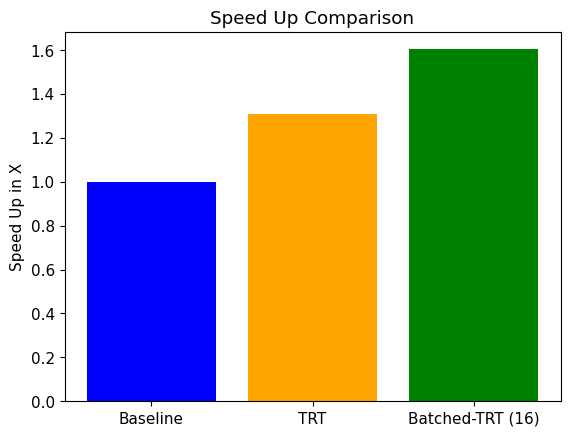

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

speed_up_values = [mat / mat, mat / trt_mat, mat / batched_mat]
labels = ['Baseline', 'TRT', 'Batched-TRT (16)']

plt.bar(labels, speed_up_values, color=['blue', 'orange', 'green'])

# 라벨과 타이틀 추가
plt.ylabel('Speed Up in X')
plt.title('Speed Up Comparison')

# Plot을 그림
plt.show()